<a href="https://colab.research.google.com/github/DamienSmith/UTS_ML2019_ID13039957/blob/master/A2_PracticalProject_13039957_13026998.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A2: Algorithm Implementation | 31005 | Advanced Data Analytics
Student: 13039957 & 13026998

Link to Github:
https://github.com/DamienSmith/UTS_ML2019_ID13039957/blob/master/A2_PracticalProject_13039957_13026998.ipynb

##Introduction - a project overview (100)


**The Decision Tree (CART) Algorithm** 

A decision tree is a tree in which each branch node represents a choice between a number of alternatives, and each leaf node represents a classification or decision (Singh & Gupta 2014). Starting with a root node rules are applied that split and generate new nodes recursively according to a learning algorithm resulting in a decision tree where each edge represents a question and its outcome (Peng, Chen & Zhou 2009). Common decision tree algorithms include ID3, CART and C4.5 which each use different splitting criteria for splitting a node at each level to find a node with the least possible solutions (Singh & Gupta 2014). 

For this project, the CART (Classification and Regression Trees) algorithm will be implemented from scratch. The representation of the CART model is a binary tree where each node can have zero, one or two child nodes (Brownlee 2016). All input variables and all possible split points are evaluated and chosen in a greedy manner based on the cost function. The Gini cost function is used which provides an purity score which represents how mixed the training data assigned to each node is. A split is made on the best score at each level of depth. Splitting continues until nodes contain a minimum number of training examples or a maximum tree depth is reached. Once created, a tree can be navigated with a new row of data following each branch with the splits until a final prediction is made.

**Define Input/Output** 
* What data you use and what you’re getting out
* the format of the I/O data

The data we are using is the iris dataset, however, this algorithm is designed to handle any dataset as long as it is inputted as a pandas dataframe. Pandas is a Python library providing integrated, intuitive routines for performing common data manipulations and analysis on data sets (McKinney 2011). After running the algorithm, the predicted value of each row of the testing dataframe will be printed in the command line. 


##Exploration (300)

**Identify Challenges**

* Highlight the practical significance of the project
* What problems exist and how to manage them
  * e.g. memory management, time efficiency, 'advanced functions' (eg parallelism) 

**Design Data Structures**

* Design/planning of research/development is clear and logical
* Cover these:
  * data acquisition
  * quality control
  * modelling technicques
  * evaluation method & criteria

**Plan Data Models and Tests**

* Logical design (correct, efficient and practically complete)
* Evaluation method/Testing (Compare and consider alternatives)
* Must be able to run code through collab 
  * i.e. data load and python libraries need to work in Collab


**Possible alternatives**

* Algorithm Tuning. The application of CART to the Bank Note dataset was not tuned. Experiment with different parameter values and see if you can achieve better performance.

* Cross Entropy. Another cost function for evaluating splits is cross entropy (logloss). You could implement and experiment with this alternative cost function.

* Tree Pruning. An important technique for reducing overfitting of the training dataset is to prune the trees. Investigate and implement tree pruning methods.

* Categorical Dataset. The example was designed for input data with numerical or ordinal input attributes, experiment with categorical input data and splits that may use equality instead of ranking.

* Regression. Adapt the tree for regression using a different cost function and method for creating terminal nodes.

* More Datasets. Apply the algorithm to more datasets on the UCI Machine Learning Repository.



There several choices there is historically ID3 the Iterative Dichotomiser 3, C5 which I believe stands for Classifier as development of ID3. CART, which is for classification and regression tree. It's very common in Universal Choice. CHAID, which is for CHi-squared Automatic Interaction Detectior. MARS, which is multivariate adaptive regression splines. And the one that I'm going to be using Conditional Inference trees. Now decision trees in general have some pros and cons.



##Methodology (100 ex comments)

[code here]

**Build and Train Data Models**

* Comments connect the code to the algorithm steps
* 





## Decision Tree Model

In [0]:
## 
##    A2: Algorithm Implementation | 31005 | Advanced Data Analytics
##    
##    Authors: Rae Ho (13026998) & Damien Smith (13039957)
##    Goals: - Implement Decision Tree Algorithm
##           - Build & Train a model
##           - Explore/Compare different parameters 
##    Code: Python 3
##    Github: https://github.com/DamienSmith/UTS_ML2019_ID13039957/blob/master/A2_PracticalProject_13039957_13026998.ipynb
##
##

# Import Libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_profiling as pp
from sklearn import datasets

# Load Data
# Just some test data
dataset = datasets.load_iris()
X = dataset.data[:, [0, 2]]
y = dataset.target
dataset
# Get dataset from github
# url = 'https://raw.githubusercontent.com/DamienSmith/UTS_ML2019_ID13039957/master/characters.csv'
# df = pd.read_csv(url)

#Data profiling
#pp.ProfileReport(dataset)

In [0]:
# Define Gini_index() Function 
# Calculate the Gini index for a split dataset

def gini_index(groups, classes):
	# count all samples at split point
	n_instances = float(sum([len(group) for group in groups]))
	# sum weighted Gini index for each group
	gini = 0.0
	for group in groups:
		size = float(len(group))
		# avoid divide by zero
		if size == 0:
			continue
		score = 0.0
		# score the group based on the score for each class
		for class_val in classes:
			p = [row[-1] for row in group].count(class_val) / size
			score += p * p
		# weight the group score by its relative size
		gini += (1.0 - score) * (size / n_instances)
	return gini


In [0]:
# Define test_split() Function.
# Separate the dataset into two lists of rows given the index of an attribute and a split value for that attribute.
# Once we have the two groups, we can then use our Gini score above to evaluate the cost of the split.
# Note: The right group contains all rows with a value at the index above or equal to the split value.

# Split a dataset based on an attribute and an attribute value
def test_split(index, value, dataset):
	left, right = list(), list()
	for row in dataset:
		if row[index] < value:
			left.append(row)
		else:
			right.append(row)
	return left, right


# Splitting a dataset involves iterating over each row, checking if the attribute value is below or above the split value and assigning it to the left or right group respectively.

In [0]:
# Define get_split() Function.
# With the Gini function above and the test split function we now have everything we need to evaluate splits.
# Given a dataset, we must check every value on each attribute as a candidate split, evaluate the cost of the split and find the best possible split we could make.
# Once the best split is found, we can use it as a node in our decision tree

def get_split(dataset):
	class_values = list(set(row[-1] for row in dataset))
	b_index, b_value, b_score, b_groups = 999, 999, 999, None
	for index in range(len(dataset[0])-1):
		for row in dataset:
			groups = test_split(index, row[index], dataset)
			gini = gini_index(groups, class_values)
			print('X%d < %.3f Gini=%.3f' % ((index+1), row[index], gini))
			if gini < b_score:
				b_index, b_value, b_score, b_groups = index, row[index], gini, groups
	return {'index':b_index, 'value':b_value, 'groups':b_groups}

In [0]:
# Calculate the Gini index for a split dataset
def gini_index(groups, classes):
	# count all samples at split point
	n_instances = float(sum([len(group) for group in groups]))
	# sum weighted Gini index for each group
	gini = 0.0
	for group in groups:
		size = float(len(group))
		# avoid divide by zero
		if size == 0:
			continue
		score = 0.0
		# score the group based on the score for each class
		for class_val in classes:
			p = [row[-1] for row in group].count(class_val) / size
			score += p * p
		# weight the group score by its relative size
		gini += (1.0 - score) * (size / n_instances)
	return gini

# Split a dataset based on an attribute and an attribute value
def test_split(index, value, dataset):
	left, right = list(), list()
	for row in dataset:
		if row[index] < value:
			left.append(row)
		else:
			right.append(row)
	return left, right

# Select the best split point for a dataset
def get_split(dataset):
	class_values = list(set(row[-1] for row in dataset))
	b_index, b_value, b_score, b_groups = 999, 999, 999, None
	for index in range(len(dataset[0])-1):
		for row in dataset:
			groups = test_split(index, row[index], dataset)
			gini = gini_index(groups, class_values)
			print('X%d < %.3f Gini=%.3f' % ((index+1), row[index], gini))
			if gini < b_score:
				b_index, b_value, b_score, b_groups = index, row[index], gini, groups
	return {'index':b_index, 'value':b_value, 'groups':b_groups}
 
split = get_split(dataset)
print('Split: [X%d < %.3f]' % ((split['index']+1), split['value']))

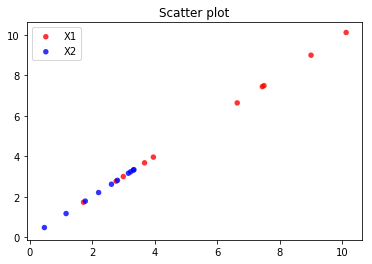

In [0]:
# plot scatter plot - needs work
x = [row[0] for row in dataset]
y = [row[1] for row in dataset]

data = x,y
colors = ("red", "blue")
groups = ("X1", "X2")

# Create plot
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

for data, color, group in zip(data, colors, groups):
  x = data
  y = data
  ax.scatter(x, y, alpha=0.8, c=color, edgecolors='none', s=30, label=group)

plt.title('Scatter plot')
plt.legend(loc=2)
plt.show()

In [0]:
# We need to control the size of a tree by defining the depth and the number of rows that a node will run.

# We use user-defined arguments to define tree building procedure.
# Maximum Tree Depth. This is the maximum number of nodes from the root node of the tree. Once a maximum depth of the tree is met, we must stop splitting adding new nodes. Deeper trees are more complex and are more likely to overfit the training data.
# Minimum Node Records. This is the minimum number of training patterns that a given node is responsible for. Once at or below this minimum, we must stop splitting and adding new nodes. Nodes that account for too few training patterns are expected to be too specific and are likely to overfit the training data.

# There is one more condition. It is possible to choose a split in which all rows belong to one group. In this case, we will be unable to continue splitting and adding child nodes as we will have no records to split on one side or another.

# Now we have some ideas of when to stop growing the tree. When we do stop growing at a given point, that node is called a terminal node and is used to make a final prediction.

# This is done by taking the group of rows assigned to that node and selecting the most common class value in the group. This will be used to make predictions.


# Define to_terminal() Function
# Select a class value for a group of rows. It returns the most common output value in a list of rows.
def to_terminal(group):
	outcomes = [row[-1] for row in group]
	return max(set(outcomes), key=outcomes.count)

In [0]:
# # Split a dataset based on an attribute and an attribute value
def test_split(index, value, dataset):
	left, right = list(), list()
	for row in dataset:
		if row[index] < value:
			left.append(row)
		else:
			right.append(row)
	return left, right
 
# Calculate the Gini index for a split dataset
def gini_index(groups, classes):
	# count all samples at split point
	n_instances = float(sum([len(group) for group in groups]))
	# sum weighted Gini index for each group
	gini = 0.0
	for group in groups:
		size = float(len(group))
		# avoid divide by zero
		if size == 0:
			continue
		score = 0.0
		# score the group based on the score for each class
		for class_val in classes:
			p = [row[-1] for row in group].count(class_val) / size
			score += p * p
		# weight the group score by its relative size
		gini += (1.0 - score) * (size / n_instances)
	return gini
 
# Select the best split point for a dataset
def get_split(dataset):
	class_values = list(set(row[-1] for row in dataset))
	b_index, b_value, b_score, b_groups = 999, 999, 999, None
	for index in range(len(dataset[0])-1):
		for row in dataset:
			groups = test_split(index, row[index], dataset)
			gini = gini_index(groups, class_values)
			if gini < b_score:
				b_index, b_value, b_score, b_groups = index, row[index], gini, groups
	return {'index':b_index, 'value':b_value, 'groups':b_groups}
 
# Create a terminal node value
def to_terminal(group):
	outcomes = [row[-1] for row in group]
	return max(set(outcomes), key=outcomes.count)
 
# Create child splits for a node or make terminal
def split(node, max_depth, min_size, depth):
	left, right = node['groups']
	del(node['groups'])
	# check for a no split
	if not left or not right:
		node['left'] = node['right'] = to_terminal(left + right)
		return
	# check for max depth
	if depth >= max_depth:
		node['left'], node['right'] = to_terminal(left), to_terminal(right)
		return
	# process left child
	if len(left) <= min_size:
		node['left'] = to_terminal(left)
	else:
		node['left'] = get_split(left)
		split(node['left'], max_depth, min_size, depth+1)
	# process right child
	if len(right) <= min_size:
		node['right'] = to_terminal(right)
	else:
		node['right'] = get_split(right)
		split(node['right'], max_depth, min_size, depth+1)
    
# Build a decision tree
def build_tree(train, max_depth, min_size):
	root = get_split(train)
	split(root, max_depth, min_size, 1)
	return root
 
# Print a decision tree
def print_tree(node, depth=0):
	if isinstance(node, dict):
		print('%s[X%d < %.3f]' % ((depth*' ', (node['index']+1), node['value'])))
		print_tree(node['left'], depth+1)
		print_tree(node['right'], depth+1)
	else:
		print('%s[%s]' % ((depth*' ', node)))

tree = build_tree(dataset, 1, 1)
print_tree(tree)

[X1 < 6.642]
 [0]
 [1]


In [0]:
## show some experimenting with different 'max depth' parameters

##

##



In [0]:
# Make a prediction with a decision tree
def predict(node, row):
	if row[node['index']] < node['value']:
		if isinstance(node['left'], dict):
			return predict(node['left'], row)
		else:
			return node['left']
	else:
		if isinstance(node['right'], dict):
			return predict(node['right'], row)
		else:
			return node['right']
    
#  predict with a stump
stump = {'index': 0, 'right': 1, 'value': 6.642287351, 'left': 0}
for row in dataset:
	prediction = predict(stump, row)
	print('Predicted=%d, Result=%d' % (row[-1], prediction))

Predicted=0, Result=0
Predicted=0, Result=0
Predicted=0, Result=0
Predicted=0, Result=0
Predicted=0, Result=0
Predicted=1, Result=1
Predicted=1, Result=1
Predicted=1, Result=1
Predicted=1, Result=1
Predicted=1, Result=1


In [0]:
## Comparisons

## Regression?


In [0]:
#
# ID3 Decision Tree (Information Gain)
#

def find_entropy(df):
    Class = df.keys()[-1]   #To make the code generic, changing target variable class name
    entropy = 0
    values = df[Class].unique()
    for value in values:
        fraction = df[Class].value_counts()[value]/len(df[Class])
        entropy += -fraction*np.log2(fraction)
    return entropy
  
  
def find_entropy_attribute(df,attribute):
  Class = df.keys()[-1]   #To make the code generic, changing target variable class name
  target_variables = df[Class].unique()  #This gives all 'Yes' and 'No'
  variables = df[attribute].unique()    #This gives different features in that attribute (like 'Hot','Cold' in Temperature)
  entropy2 = 0
  for variable in variables:
      entropy = 0
      for target_variable in target_variables:
          num = len(df[attribute][df[attribute]==variable][df[Class] ==target_variable])
          den = len(df[attribute][df[attribute]==variable])
          fraction = num/(den+eps)
          entropy += -fraction*log(fraction+eps)
      fraction2 = den/len(df)
      entropy2 += -fraction2*entropy
  return abs(entropy2)


def find_winner(df):
    Entropy_att = []
    IG = []
    for key in df.keys()[:-1]:
#         Entropy_att.append(find_entropy_attribute(df,key))
        IG.append(find_entropy(df)-find_entropy_attribute(df,key))
    return df.keys()[:-1][np.argmax(IG)]
  
  
def get_subtable(df, node,value):
  return df[df[node] == value].reset_index(drop=True)


def buildTree(df,tree=None): 
    Class = df.keys()[-1]   #To make the code generic, changing target variable class name
    
    #Here we build our decision tree

    #Get attribute with maximum information gain
    node = find_winner(df)
    
    #Get distinct value of that attribute e.g Salary is node and Low,Med and High are values
    attValue = np.unique(df[node])
    
    #Create an empty dictionary to create tree    
    if tree is None:                    
        tree={}
        tree[node] = {}
    
   #We make loop to construct a tree by calling this function recursively. 
    #In this we check if the subset is pure and stops if it is pure. 

    for value in attValue:
        
        subtable = get_subtable(df,node,value)
        clValue,counts = np.unique(subtable['Eat'],return_counts=True)                        
        
        if len(counts)==1:#Checking purity of subset
            tree[node][value] = clValue[0]                                                    
        else:        
            tree[node][value] = buildTree(subtable) #Calling the function recursively 
                   
    return tree

In [0]:
def predict(inst,tree):
    #This function is used to predict for any input variable 
    
    #Recursively we go through the tree that we built earlier

    for nodes in tree.keys():        
        
        value = inst[nodes]
        tree = tree[nodes][value]
        prediction = 0
            
        if type(tree) is dict:
            prediction = predict(inst, tree)
        else:
            prediction = tree
            break;                            
        
    return prediction

In [0]:
## Show comparison with a Large/small dataset

## Show comparison of predictive accuracy between Decision Trees

##Evaluation (200)


**Report Execution on Data**

**Report Testing**

**Efficiency Analysis**

**Comparative Study**

ideas:
* how does each feature distribution look like? Are there any differences between feature distribution in train and test data?
* are there any meaningful interactions between the features?
* are there outliers and can they be explained?
* are there missing values or duplicates? What are reasons for them?


## Conclusion (100)


Discuss Reflections

Propose Possible Improvements



## Ethical (200)

* Discuss the social/ethical aspect of the project
  * adopt an ethical model (e.g. Ultitarian or Kantian)
* Consider how the technique could be misused

## Video Pitch

[url to video]

**Highlight Challenges and Effort**

* Describe challenges and how the team addressed them.
  * Python Skills
    * Pandas, numpy, others?
    * Dictionary (Hashmap)
  * Code structure
    * Generating 'depth' and 'terminal' flags in dictionary
    * Handling looping (to avoid hardcoding for iris and adding flexibility to use any dataframe)
  * Managing Assignment scope 
    * We initially wanted to run each cost function (ID3, CART and C4.5) (entropy? info gain?)
    * We also wanted to turn it into a Random forest
    * scoping this down into the time we had available was a challenge (while learning)

## References

Brownlee, J., 2016. Master Machine Learning Algorithms: discover how they work and implement them from scratch. Machine Learning Mastery.

McKinney, W., 2011. pandas: a foundational Python library for data analysis and statistics. Python for High Performance and Scientific Computing, 14.

Peng, W., Chen, J. and Zhou, H., 2009. An implementation of ID3-decision tree learning algorithm. From web.arch.usyd.edu.au/wpeng/DecisionTree2.pdf viewed 21/09/2019

Singh, S. & Gupta, P., 2014. Comparative study ID3, cart and C4. 5 decision tree algorithm: a survey. International Journal of Advanced Information Science and Technology (IJAIST), 27(27), pp.97-103.
